In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import math

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
!pip install wandb
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Use scipy to load .mat file which returns a dictionary
data = loadmat('/kaggle/input/svhn-dataset/train_32x32.mat')

In [5]:
X, y = data['X'], data['y']
X = X.transpose()
# Target values are from 1-10 while a CNN model expects them to be from 0-9 so we subtract 1
y -= 1

In [6]:
min(y), max(y)

(array([0], dtype=uint8), array([9], dtype=uint8))

In [7]:
print(f"X shape: {X.shape} and y shape: {y.shape}")
# 73257 32 by 32 pixel images with 3 color channels 

X shape: (73257, 3, 32, 32) and y shape: (73257, 1)


In [8]:
# Perform dataset split train:val:test 70:20:10
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.1*len(X)/len(y_test), random_state=42)

In [9]:
print(f"Size of training data: {len(X_train)} \nSize of validation data: {len(X_valid)} \nSize of testing data: {len(X_test)}")

Size of training data: 51279 
Size of validation data: 14652 
Size of testing data: 7326


In [10]:
# Create custom dataset class
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=True):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        transform = transforms.ToTensor()
        
        x = transform(x)
        x = x.permute(1,0,2)
        return x, y
    
    def __len__(self):
        return len(self.data)

In [23]:
# Create dataloader objects for train, test, val
train_data = MyDataset(X_train, y_train)
valid_data = MyDataset(X_valid, y_valid)
test_data = MyDataset(X_test, y_test)
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size=1, shuffle=True)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64, 1])


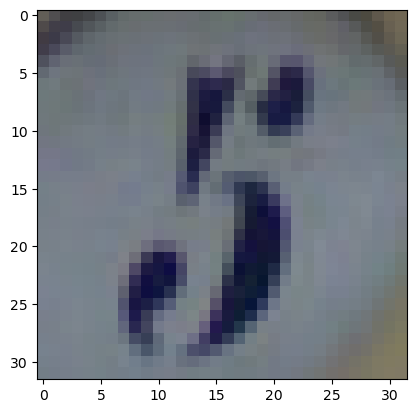

Label: tensor([5])


In [12]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label+1}")

(array([11919.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2733.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

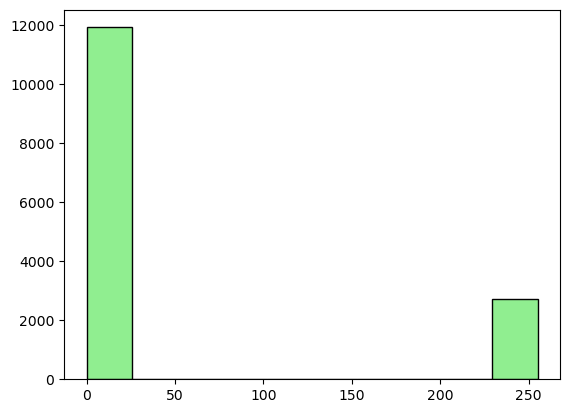

In [70]:
plt.hist(y_valid, color='lightgreen', ec='black', bins=10)

# Train a CNN from scratch

In [13]:
# # Define a CNN with 2 conv layers and a single fc layer
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 conv layers to extract features from the input
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, # outputs 32 feature maps
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, # ouputs 64 feature maps
                               kernel_size=3, padding=1)
        # A fully-connected (fc) layer takes a weighted sum of all its inputs, and applies
        # an activation function to produce output
        self.fc1 = nn.Linear(64*32*32, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x


model = Net()
if torch.cuda.is_available():
    model.cuda()

In [14]:
# !pip install torchsummary
# from torchsummary import summary

# summary(model, (3, 32, 32))

In [14]:
# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Define validation of model
def validate_model(model, valid_dl, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass ➡
            outputs = model(images)
            val_loss += loss_func(outputs, torch.flatten(labels))*64

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += ((predicted == torch.flatten(labels)).sum().item())
            
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)


In [19]:
def wandb_run():
    # 🐝 initialise a wandb run
    wandb.init(
        project="image-classification",
        config={
            "epochs": 5,
            "batch_size": 64,
            "lr": 0.001,
            })

    # Copy your config 
    config = wandb.config

    # No. of batches for training
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # Training
    example_ct = 0
    step_ct = 0
    for epoch in range(config.epochs):
        model.train()
        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            train_loss = loss_func(outputs, torch.flatten(labels))  # 
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {"train/train_loss": train_loss, 
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                       "train/example_ct": example_ct}

            if step + 1 < n_steps_per_epoch:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)

            step_ct += 1

        val_loss, accuracy = validate_model(model, valid_dl, loss_func)

        # 🐝 Log train and validation metrics to wandb
        val_metrics = {"val/val_loss": val_loss, 
                       "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})

        print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

    # # If you had a test set, this is how you could log it as a Summary metric
    # wandb.summary['test_accuracy'] = 0.8

    # 🐝 Close your wandb run 
    wandb.finish()

In [20]:
# torch.save(model, 'model_pytorch.pt')

In [21]:
from sklearn.metrics import f1_score
def test_model(model, test_dl):
#     wandb.init(project="image-classification")
    model.eval()
    with torch.inference_mode():
        correct = 0
        f1 = 0
        y_true = []
        y_pred = []
        
        for i, (images, labels) in enumerate(test_dl):
            images, labels = images.to(device), labels.to(device)
            # Forward pass ➡
            outputs = model(images)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += ((predicted == torch.flatten(labels)).sum().item())

            y_true.extend(torch.flatten(labels))
            y_pred.extend(predicted)
    
#     wandb.sklearn.plot_confusion_matrix(y_true, y_pred)
#     i = 0
#     misclass = {key: [] for key in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}
#     for j, (images, labels) in enumerate(test_dl):
#         for img in images:
#             if y_pred[i] != y_true[i]:
#                 misclass[y_true[i].item()].append(list([img, y_true[i]+1]))
#             i += 1
    f1 = f1_score(y_true, y_pred, average='weighted')
    return correct / len(test_dl.dataset), f1

    

In [22]:
wandb_run()

Train Loss: 0.814, Valid Loss: 0.780571, Accuracy: 0.78
Train Loss: 0.363, Valid Loss: 0.684429, Accuracy: 0.80
Train Loss: 0.628, Valid Loss: 0.634796, Accuracy: 0.82
Train Loss: 0.699, Valid Loss: 0.655916, Accuracy: 0.82
Train Loss: 0.227, Valid Loss: 0.654317, Accuracy: 0.81


train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,██▆▅▃▄▃▂▃▁▃▂▃▂▂▂▂▁▂▂▃▃▂▁▁▁▃▂▂▂▂▂▁▂▂▁▁▂▁▂
val/val_accuracy,▁▅█▇▆
val/val_loss,█▃▁▂▂
train/epoch,5.0
train/example_ct,256395
train/train_loss,0.22702
val/val_accuracy,0.81108
val/val_loss,0.65432


# PG Question

Misclassified in class:  1
Predicted class: 4


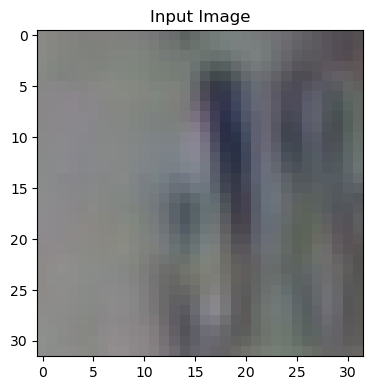

Predicted class: 9


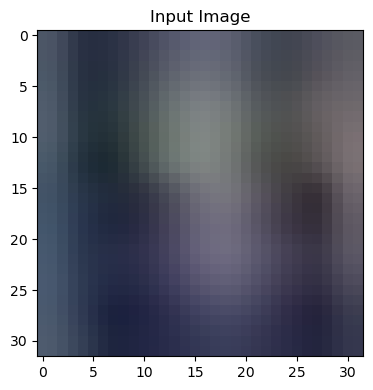

Predicted class: 6


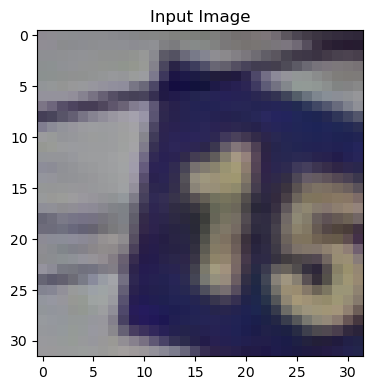

Misclassified in class:  2
Predicted class: 7


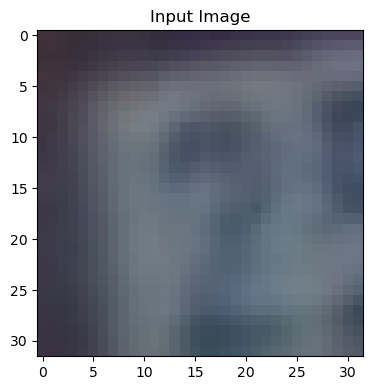

Predicted class: 4


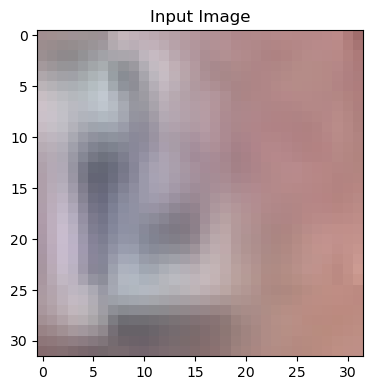

Predicted class: 1


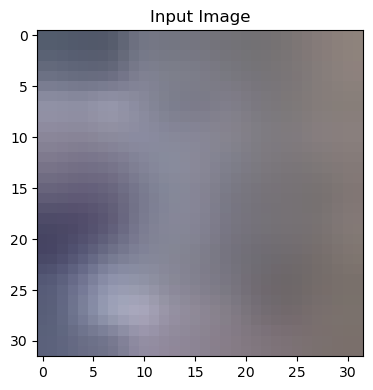

Misclassified in class:  3
Predicted class: 5


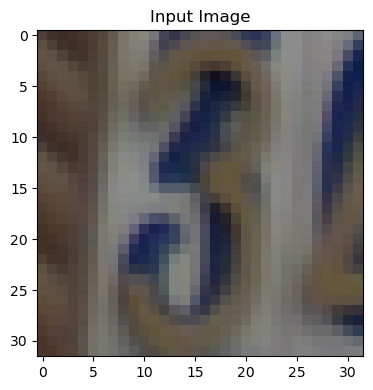

Predicted class: 5


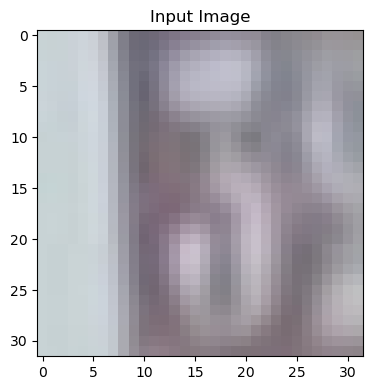

Predicted class: 2


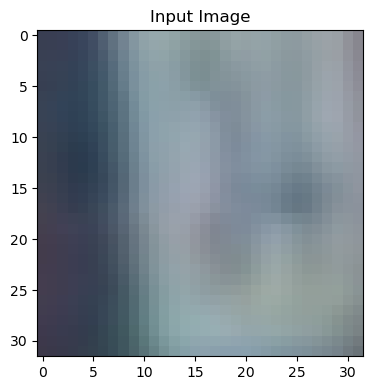

Misclassified in class:  4
Predicted class: 8


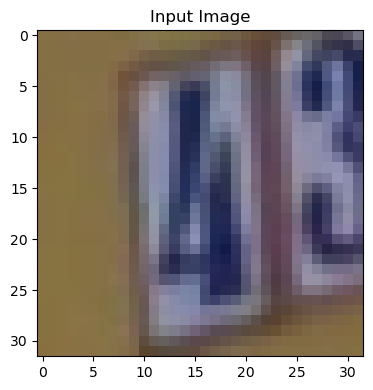

Predicted class: 6


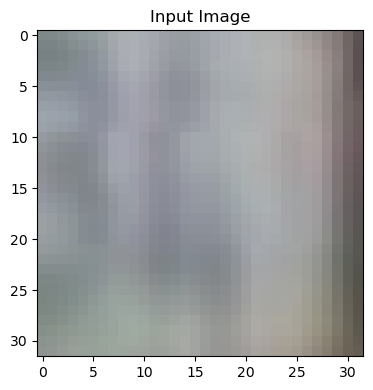

Predicted class: 1


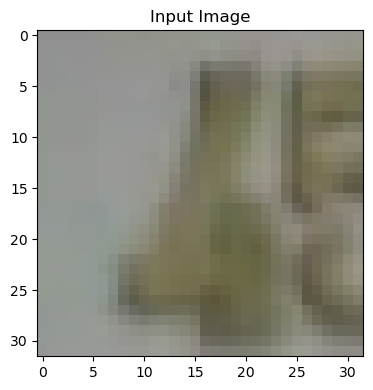

Misclassified in class:  5
Predicted class: 1


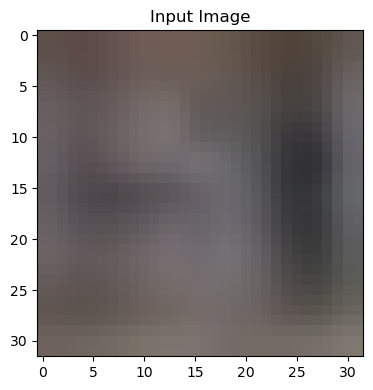

Predicted class: 3


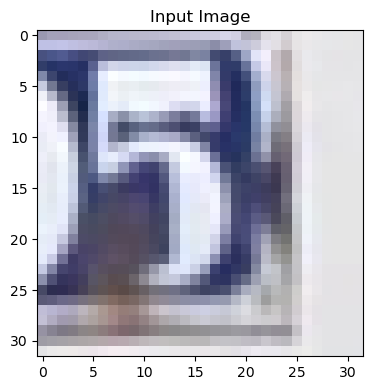

Predicted class: 3


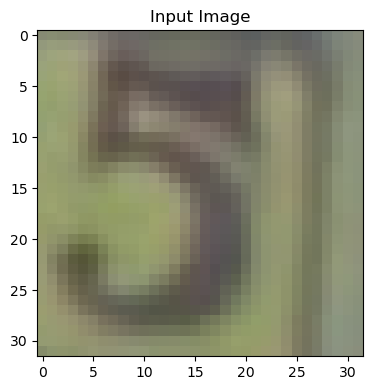

Misclassified in class:  6
Predicted class: 8


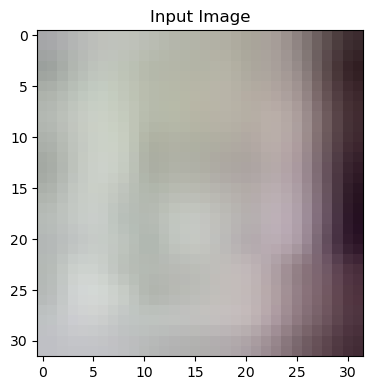

Predicted class: 3


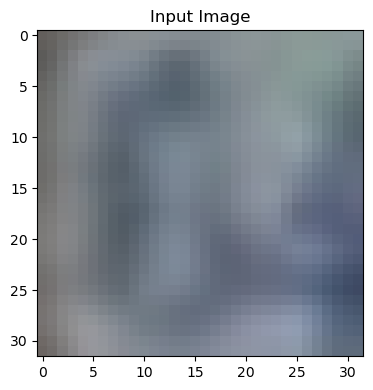

Predicted class: 8


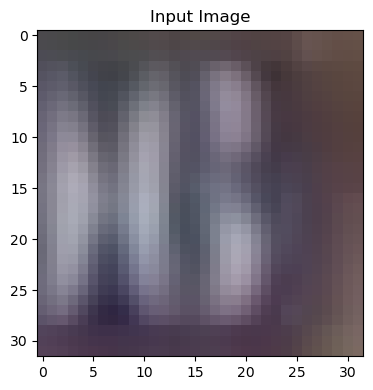

Misclassified in class:  7
Predicted class: 1


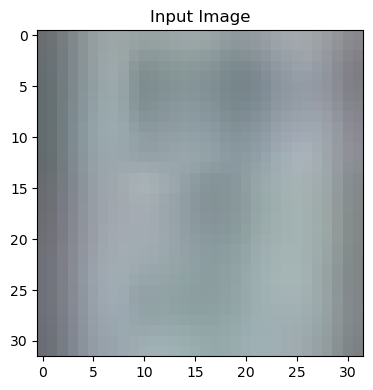

Predicted class: 1


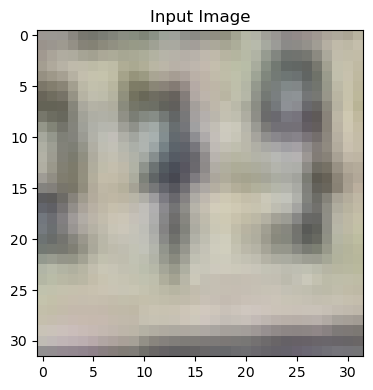

Predicted class: 3


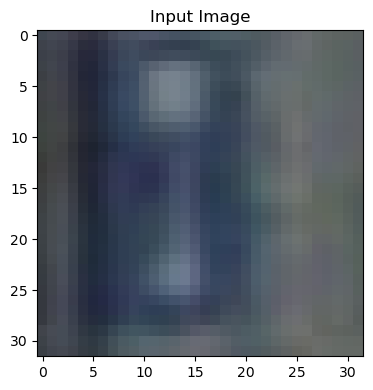

Misclassified in class:  8
Predicted class: 1


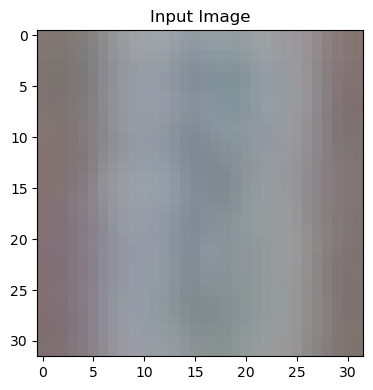

Predicted class: 2


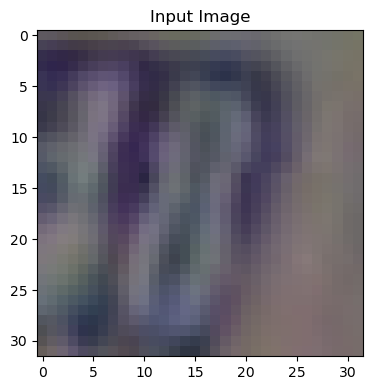

Predicted class: 6


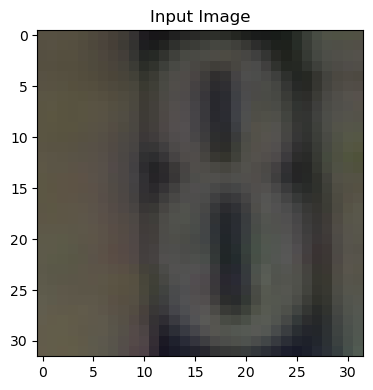

Misclassified in class:  9
Predicted class: 6


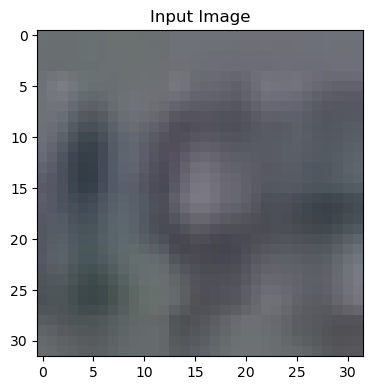

Predicted class: 1


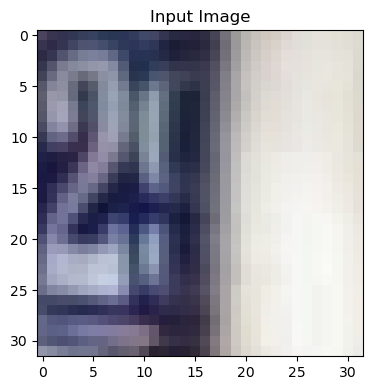

Predicted class: 8


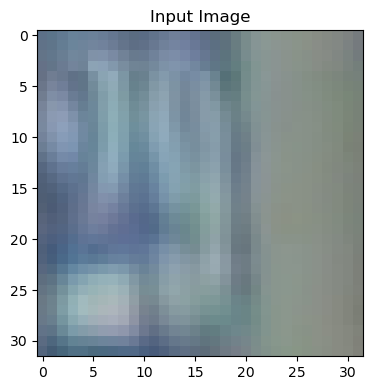

Misclassified in class:  10
Predicted class: 8


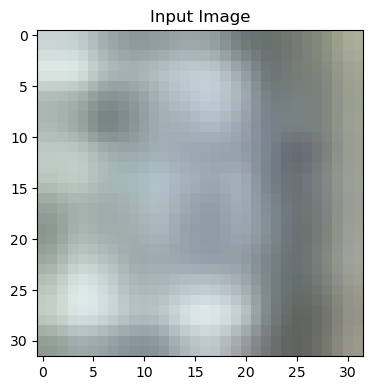

Predicted class: 6


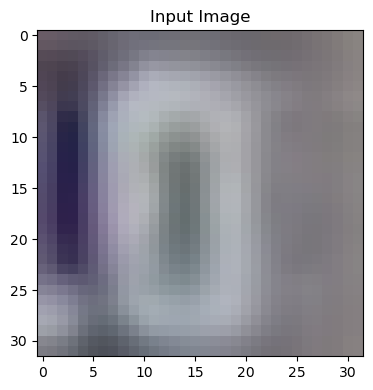

Predicted class: 1


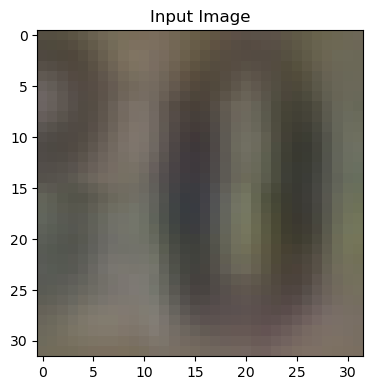

In [38]:
num_classes = 10
model.eval()
# Initialize a list to store images and masks for visualization

class_samples = {i : [] for i in range (num_classes)}
# Iterate through the test set
with torch.no_grad():
    for images, targets in test_dl:  # Assuming test_dl provides inputs and target masks
        # Forward pass to get predictions
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        targets = torch.flatten(targets).item()
        predicted = predicted.item()
        images = images.cpu().squeeze().permute(1, 2, 0).numpy()
        # Convert to NumPy arrays
        if  predicted != targets and len(class_samples[targets]) < 3:
            class_samples[targets].append([images, predicted])

# Visualize the selected images (up to 3 per class)

for class_idx in range(num_classes):
    print("Misclassified in class: ", class_idx+1)
    for t in class_samples[class_idx]:
        input_img = t[0]

        # Visualize the image, predicted mask, and target mask using Matplotlib
        plt.figure(figsize=(4, 4))
        plt.subplot()
        plt.imshow(input_img)  # Assuming input_img is a tensor
        plt.title('Input Image')
        
        print('Predicted class:', t[1]+1)

        plt.tight_layout()
        plt.show()

In [17]:
model = torch.load('/kaggle/input/model-resnet/model_pytorch_resnet.pt')

In [25]:
test_acc, f1 = test_model(model, test_dl)
print(f"Test accuracy: {test_acc:.2f}\nF1 score: {f1:.2f}")

Test accuracy: 0.94
F1 score: 0.94


In [29]:
test_acc, f1 = test_model(model, test_dl)
print(f"Test accuracy: {test_acc:.2f}\nF1 score: {f1:.2f}")

Test accuracy: 0.83
F1 score: 95.47


In [ ]:
def visualise_misclassified(model, test_dl):
    

# Fine tune a pre-trained model

In [22]:
# Load pre-trained model
import torchvision.models as models
model = models.resnet18(weights='ResNet18_Weights.DEFAULT', progress=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s] 


In [23]:
# Define final layer
import torch.nn as nn
import torch.nn.functional as F
num_classes = 10
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

In [28]:
wandb_run()

wandb: Currently logged in as: ana427. Use `wandb login --relogin` to force relogin


Train Loss: 1.160, Valid Loss: 0.416955, Accuracy: 0.87
Train Loss: 0.194, Valid Loss: 0.342449, Accuracy: 0.90
Train Loss: 0.240, Valid Loss: 0.325474, Accuracy: 0.90
Train Loss: 0.057, Valid Loss: 0.280979, Accuracy: 0.92
Train Loss: 0.227, Valid Loss: 0.281111, Accuracy: 0.92


train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▆▆▄▃▅▄▂▃▂▂▃▃▅▃▂▂▂▂▄▂▂▂▂▂▂▃▃▁▂▁▂▁▁▁▂▁▂▁▁
val/val_accuracy,▁▅▆██
val/val_loss,█▄▃▁▁
train/epoch,5.0
train/example_ct,256395
train/train_loss,0.22723
val/val_accuracy,0.91769
val/val_loss,0.28111


In [30]:
torch.save(model, 'model_pytorch_resnet.pt')

In [35]:
test_acc, f1 = test_model(model, test_dl)
print(f"Test accuracy: {test_acc:.2f}\nF1 score: {f1:.2f}")

Test accuracy: 0.92
F1 score: 105.83


In [34]:
# Visualising extracted features (from backbone ResNet18) using a tSNE plot

def get_fv(dl):
    # Load the pre-trained ResNet-18 model
    resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT', progress=True)
    # Remove the final classification layer
    resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    # Set the model to evaluation mode
    resnet.eval()
    
    feature_vectors = []
    for i, (images, labels) in enumerate(dl):
        for image in images:
            feature_vectors.append(extract_features(image, resnet))
    
    # Perform t-SNE dimensionality reduction
    feature_vectors = np.asarray(feature_vectors)
    return feature_vectors

# Define a function to extract features from an image using ResNet-18
def extract_features(image, resnet):
    with torch.no_grad():
        features = resnet(image.unsqueeze(0))  # Pass the image through ResNet
    return features.view(-1).numpy()  # Flatten and convert to NumPy array



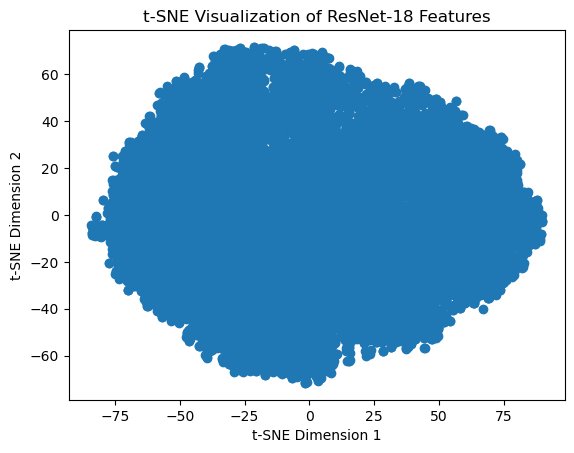

In [35]:
feature_vectors = get_fv(valid_dl)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(feature_vectors)

# Visualize the t-SNE results
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title("t-SNE Visualization of ResNet-18 Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

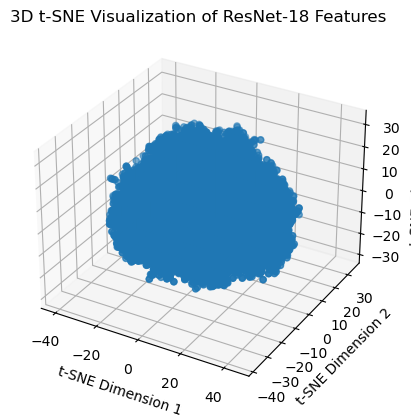

In [39]:
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(feature_vectors)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2])
ax.set_title("3D t-SNE Visualization of ResNet-18 Features")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
plt.show()

## Data Augmentation

In [25]:
# Create custom dataset class
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=True):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        transform = transforms.ToTensor()
        
        x = transform(x)
        x = x.permute(1,0,2)
        return x, y
    
    def __len__(self):
        return len(self.data)

transform = transforms.Compose([transforms.AutoAugment(), transforms.ToTensor()])

In [26]:
# Create dataloader objects for train, test, val
train_data = MyDataset(X_train, y_train, transform=transform)
valid_data = MyDataset(X_valid, y_valid, transform=transform)
test_data = MyDataset(X_test, y_test, transform=transform)
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size=64, shuffle=True)

In [27]:
len(train_dl.dataset), len(valid_dl.dataset), len(test_dl.dataset)

(51279, 14652, 7326)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64, 1])


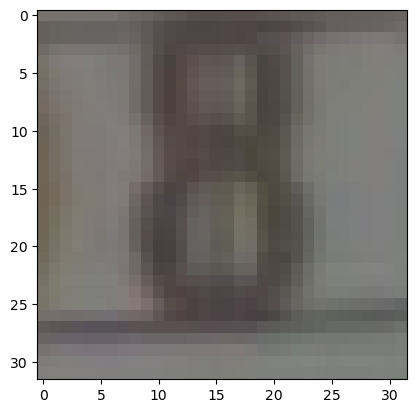

Label: tensor([8])


In [42]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label+1}")

In [ ]:
wandb_run()

wandb: Currently logged in as: ana427. Use `wandb login --relogin` to force relogin


Train Loss: 0.759, Valid Loss: 0.389174, Accuracy: 0.88
Train Loss: 0.510, Valid Loss: 0.326127, Accuracy: 0.90
Train Loss: 1.302, Valid Loss: 0.315311, Accuracy: 0.91


In [38]:
test_acc, f1 = test_model(model, test_dl)
print(f"Test accuracy: {test_acc:.2f}\nF1 score: {f1:.2f}")

Test accuracy: 0.91
F1 score: 104.33
